<a href="https://colab.research.google.com/github/shamp00/ra_colabs/blob/master/Relational_priming_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Relational priming dataset explorations

This notebook is an exploration of datasets inspired by the paper *[Analogy as relational priming: A developmental and computational perspective on the origins of a complex cognitive skill](https://pdfs.semanticscholar.org/2010/a1d46f7d46dd464343f3b830bed5b4466934.pdf)*.  Leech, Mareschal, and Cooper, “Analogy as Relational Priming.”


## Preliminaries

*   Import packages
*   Authenticate with Google Sheets
*   Fetch data from Google Sheets

In [0]:
!pip install --upgrade -q gspread

from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

In [0]:
gc = gspread.authorize(GoogleCredentials.get_application_default())

# Open our new sheet and read some data.
worksheet = gc.open('Relational Priming').sheet1

# get_all_values gives a list of rows.
#rows = worksheet.get_all_values()
#print(rows)

# Convert to a DataFrame and render.
import pandas as pd
df = pd.DataFrame.from_records(rows)

# Set the column headings to the first row
df.columns = df.iloc[0]
df.reindex(df.index.drop(0))

# output the table
df

,source,causal relation,causal agent,before,after,question,answer,distractorE,distractorF,distractorG,distractorH
0,source,causal relation,causal agent,before,after,question,answer,distractorE,distractorF,distractorG,distractorH
1,GB1,cut,knife,playdoh,cut playdoh,apple,cut apple,cut bread,bruised apple,ball,banana
2,GB1,break,hand dropping,egg,broken egg,lamp,broken lamp,broken plate,lamp on,bottle,flashlight
3,GB1,wet,rain,car,wet car,hair,wet hair,wet umbrella,cut hair,fringing,beard
4,GB1,burn,match,candle,burning candle,newspaper,burning newspaper,burning pan,open newspaper,grocery bag,book
5,GB1,open,hand opening,box,open box,bottle,open bottle,open drawer,broken bottle,vase,can of pepsi
6,GB1,melt,sun,chocolate,melted chocolate,snowman,melted snowman,melted crayon,dirty snowman,scarecrow,sled
7,GB1,dirty,mud,dog,dirty dog,shorts,dirty shorts,muddy boots,wet dog,push-toy dog,pig
8,GB1,switch on,plug,TV off,TV on,hairdryer off,hairdryer on,radio on,hairdryer burning,handmixer,curling iron
9,GB2,cut,knife,loaf of bread,slice of bread,lemon,slice of lemon,slice of cake,squeezed lemon halves,yellow balloon,lemon


## Network architecture from Leech et al. 2008

![Figure 3 from Leech et al, 2008](https://drive.google.com/uc?export=view&id=1Zc_nCNUlTID-O3prL-g_e2EUWLIpq_0l)

##Build the network (non-Hebbian)

First get it working with a basic network

*  An input layer (vectorised text) 40 units for *state_before* + 4 units for *causal_agent_before*
*  A hidden layer with 44 units and `relu` activation
*  An output layer consisting of the prediction of *state_after* + 4 units for *causal_agent_after*

We choose `binary_crossentropy` as the _loss function_. We could use `mean_squared_error`, but cross-entropy is often the best when outputting probabilities. It is an information-theory quantity that measures the distance between distributions (in this case, the ground-truth distribution and our predictions).

We choose `rmsprop` as the optimizer. Keras documentation says it is good for recurrent networks. This is gradient descent with some optimisations. See [here](https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a) for some background.

We'll monitor accuracy.

In [0]:
from keras import models
from keras import layers

object_before = layers.Input(shape=(40,), name='object_before')
causal_agent_before = layers.Input(shape=(4,), name='causal_agent_before')

# combine input into one layer
combined_input = layers.concatenate([object_before, causal_agent_before], name='combined_input')

# hidden layer
hidden_layer = layers.Dense(40, name='hidden_layer')(combined_input)

# predictions
object_after = layers.Dense(40, name='object_after')(hidden_layer)
causal_agent_after = layers.Dense(4, name='causal_agent_after')(hidden_layer)

model = models.Model(inputs=[object_before, causal_agent_before], outputs=[object_after, causal_agent_after])

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
object_before (InputLayer)      (None, 40)           0                                            
__________________________________________________________________________________________________
causal_agent_before (InputLayer (None, 4)            0                                            
__________________________________________________________________________________________________
combined_input (Concatenate)    (None, 44)           0           object_before[0][0]              
                                                                 causal_agent_before[0][0]        
__________________________________________________________________________________________________
hidden_layer (Dense)            (None, 40)           1800        combined_input[0][0]             
__________

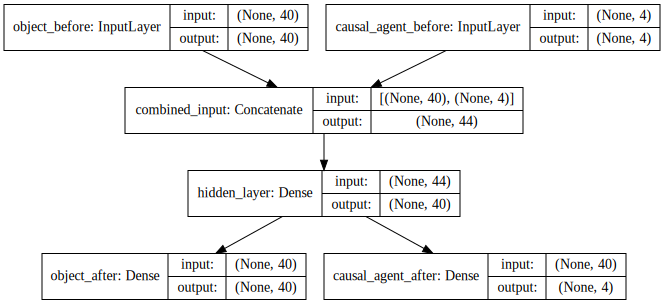

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

##Build the network (Hebbian)

This is experimental for now. 

*   Not sure how to make it bidirectional (RNN?)
*   Hebbian layers not supported out of the box so I'm using a custom layer
*   Maybe the custom layer will allow me to validate that it is performing the correct calculation

The basic architecture is

*  An input layer 40 units for *state_before* + 4 units for *causal_agent_before*
*  A hidden layer with 44 units
*  An output layer consisting of the prediction of *state_after* + 4 units for *causal_agent_after*

We could use `mean_squared_error`as the loss function (as in the paper).

We choose `rmsprop` as the optimizer.

We'll monitor accuracy.

In [0]:
#@title Hebbian learning layer implementation for Keras
'''
Implementation of a Hebbian learning layer to use as a computational module in 
building deep neural networks.

From https://stackoverflow.com/a/53981718/1077279
'''

__author__ = 'Dan Saunders'

from keras import backend as K
from keras.engine.topology import Layer

import numpy as np
import tensorflow as tf

np.set_printoptions(threshold=np.nan)

sess = tf.Session()

class Hebbian(Layer):

  def __init__(self, output_dim, lmbda=1.0, eta=0.0005, connectivity='random', connectivity_prob=0.25, **kwargs):
    '''
    Constructor for the Hebbian learning layer.

    args:
        output_dim - The shape of the output / activations computed by the layer.
        lambda - A floating-point valued parameter governing the strength of the Hebbian learning activation.
        eta - A floating-point valued parameter governing the Hebbian learning rate.
        connectivity - A string which determines the way in which the neurons in this layer are connected to
            the neurons in the previous layer.
    '''
    self.output_dim = output_dim
    self.lmbda = lmbda
    self.eta = eta
    self.connectivity = connectivity
    self.connectivity_prob = connectivity_prob

    super(Hebbian, self).__init__(**kwargs)

  def random_conn_init(self, shape, dtype=None):
    A = np.random.normal(0, 1, shape)
    A[self.B] = 0
    return tf.constant(A, dtype=tf.float32)

  def zero_init(self, shape, dtype=None):
    return np.zeros(shape)

  def build(self, input_shape):
    # create weight variable for this layer according to user-specified initialization
    if self.connectivity == 'random':
        self.B = np.random.random(input_shape[0]) < self.connectivity_prob
    elif self.connectivity == 'zero':
        self.B = np.zeros(self.output_dim)

    if self.connectivity == 'all':
        self.kernel = self.add_weight(name='kernel', shape=(np.prod(input_shape[1:]), \
                    np.prod(self.output_dim)), initializer='uniform', trainable=False)
    elif self.connectivity == 'random':
        self.kernel = self.add_weight(name='kernel', shape=(np.prod(input_shape[1:]), \
                    np.prod(self.output_dim)), initializer=self.random_conn_init, trainable=False)
    elif self.connectivity == 'zero':
        self.kernel = self.add_weight(name='kernel', shape=(np.prod(input_shape[1:]), \
                    np.prod(self.output_dim)), initializer=self.zero_init, trainable=False)
    else:
        raise NotImplementedError


    # call superclass "build" function
    super(Hebbian, self).build(input_shape)

  def call(self, x):  # x is the input to the network
    x_shape = tf.shape(x)
    batch_size = tf.shape(x)[0]

    # reshape to (batch_size, product of other dimensions) shape
    x = tf.reshape(x, (tf.reduce_prod(x_shape[1:]), batch_size))

    # compute activations using Hebbian-like update rule
    activations = x + self.lmbda * tf.matmul(self.kernel, x)  

    # compute outer product of activations matrix with itself
    outer_product = tf.matmul(tf.expand_dims(x, 1), tf.expand_dims(x, 0)) 

    # update the weight matrix of this layer
    self.kernel = self.kernel + tf.multiply(self.eta, tf.reduce_mean(outer_product, axis=2)) 
    self.kernel = tf.multiply(self.kernel, self.B)
    return K.reshape(activations, x_shape)

  def compute_output_shape(self, input_shape):
    return (input_shape[0], self.output_dim)


In [0]:
from keras import models
from keras import layers

object_before = layers.Input(shape=(40,), name='object_before')
causal_agent_before = layers.Input(shape=(4,), name='causal_agent_before')

# hidden layer
combined_input = layers.concatenate([object_before, causal_agent_before], name='combined_input')
hidden_layer = Hebbian(40, name='hidden_layer')(combined_input)

# predictions
object_after = Hebbian(40, name='object_after')(hidden_layer)
causal_agent_after = Hebbian(4, name='causal_agent_after')(hidden_layer)

model = models.Model(inputs=[object_before, causal_agent_before], outputs=[object_after, causal_agent_after])

model.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['accuracy'])

print(model.summary())


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
object_before (InputLayer)      (None, 40)           0                                            
__________________________________________________________________________________________________
causal_agent_before (InputLayer (None, 4)            0                                            
__________________________________________________________________________________________________
combined_input (Concatenate)    (None, 44)           0           object_before[0][0]              
                                                                 causal_agent_before[0][0]        
__________________________________________________________________________________________________
hidden_layer (Hebbian)          (None, 40)           1760        combined_input[0][0]             
__________

##Visualise the network architecture (Hebbian)

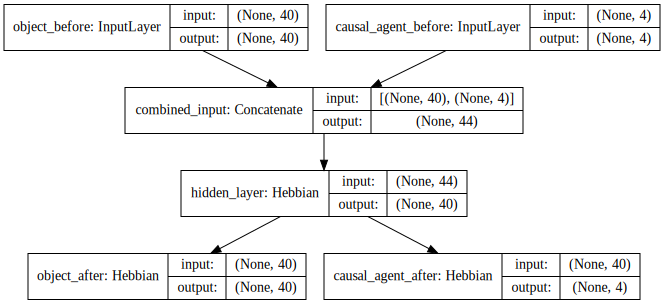

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))